# **라이브러리 설치 및 폰트 설정**

In [31]:
!pip install statsbombpy #축구 경기 데이터셋
!pip install mplsoccer   #축구장 그리기 라이브러리

import warnings
warnings.filterwarnings("ignore", message="credentials were not supplied")

# 단계 1: 폰트 설치
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get -qq -y install fonts-nanum > /dev/null
#fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'



fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

# **경기 기록 시각화**

**2018 World Cup 대한민국 VS 멕시코**

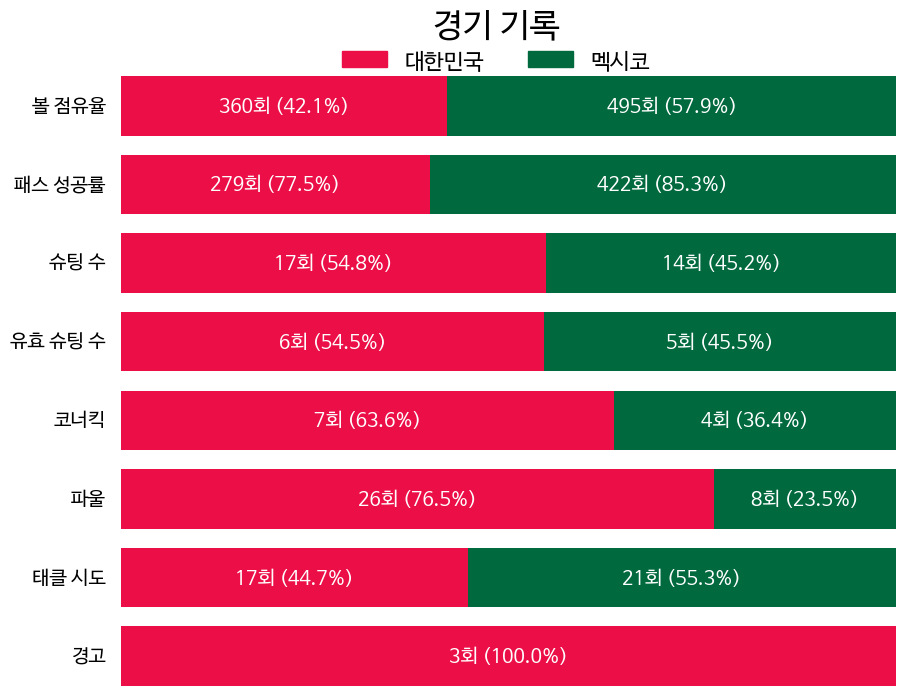

In [55]:
from statsbombpy import sb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# 0. 한글 폰트 설정 (필수)
plt.rc('font', family='NanumGothic')

# 1. 데이터 가져오기
match_id = 7553
events = sb.events(match_id=match_id)

# 팀명 한글 변환 및 정렬을 위한 헬퍼 함수
def process_data(data, target_index=None):
    name_map = {"South Korea": "대한민국", "Mexico": "멕시코"}
    data = data.rename(index=name_map)

    # 기준 인덱스(팀 목록)가 있다면 그에 맞춤
    if target_index is not None:
        data = data.reindex(target_index, fill_value=0)

    # 대한민국을 리스트의 첫 번째(왼쪽)로 배치
    if "대한민국" in data.index:
        new_order = ["대한민국"] + [t for t in data.index if t != "대한민국"]
        data = data.reindex(new_order, fill_value=0)

    return data

# --- 데이터 집계 ---

# 1) 볼 점유율 (패스 횟수)
pass_ev = events[events['type'] == 'Pass']
pass_counts = process_data(pass_ev.groupby('team').size())

# 팀 목록 기준 설정
teams_index = pass_counts.index

# 2) 패스 성공률
pass_total = process_data(pass_ev.groupby('team').size(), teams_index)
pass_success = process_data(pass_ev[pass_ev['pass_outcome'].isnull()].groupby('team').size(), teams_index)

# 3) 슈팅 수
shot_ev = events[events['type'] == 'Shot']
shot_counts = process_data(shot_ev.groupby('team').size(), teams_index)

# 4) 유효 슈팅 수
sot_outcomes = ['Goal', 'Saved', 'Saved to Post']
sot_ev = shot_ev[shot_ev['shot_outcome'].isin(sot_outcomes)]
sot_counts = process_data(sot_ev.groupby('team').size(), teams_index)

# 5) 코너킥
if 'pass_type' in events.columns:
    corner_ev = events[(events['type'] == 'Pass') & (events['pass_type'] == 'Corner')]
    corner_counts = process_data(corner_ev.groupby('team').size(), teams_index)
else:
    corner_counts = process_data(pd.Series(dtype=int), teams_index)

# 6) 파울
if 'type' in events.columns:
    foul_ev = events[events['type'] == 'Foul Committed']
    foul_counts = process_data(foul_ev.groupby('team').size(), teams_index)
else:
    foul_counts = process_data(pd.Series(dtype=int), teams_index)

# 7) 태클
if 'duel_type' in events.columns:
    tackle_ev = events[(events['type'] == 'Duel') & (events['duel_type'] == 'Tackle')]
    tackle_counts = process_data(tackle_ev.groupby('team').size(), teams_index)
else:
    tackle_counts = process_data(pd.Series(dtype=int), teams_index)

# 8) 경고 (Yellow Card)
mask_yellow = pd.Series(False, index=events.index)
if 'foul_committed_card' in events.columns:
    mask_yellow |= events['foul_committed_card'].isin(['Yellow Card', 'Second Yellow'])
if 'bad_behaviour_card' in events.columns:
    mask_yellow |= (events['bad_behaviour_card'] == 'Yellow Card')
yellow_counts = process_data(events[mask_yellow].groupby('team').size(), teams_index)


# --- 그래프 그리기 ---

fig, axes = plt.subplots(8, 1, figsize=(10, 8))
plt.subplots_adjust(top=0.88, hspace=0.20)

colors = ['#EC0F47', '#00693E'] # 대한민국(Red), 멕시코(Green)

# 제목 및 범례
fig.suptitle("경기 기록", fontsize=24, fontweight='heavy', y=0.96)
red_patch = mpatches.Patch(color=colors[0], label='대한민국')
green_patch = mpatches.Patch(color=colors[1], label='멕시코')
fig.legend(handles=[red_patch, green_patch], loc='upper center', bbox_to_anchor=(0.5, 0.935), ncol=2, frameon=False, fontsize=16)

def draw_stat_bar(ax, data, title, total_data=None):
    vis_total = data.sum()

    # 데이터가 아예 없는 경우 (예: 퇴장 0 vs 0)
    if vis_total == 0:
        ax.set_xlim(0, 1) # 좌표계 강제 설정
        # 텍스트 출력 없음 (빈 공간)
    else:
        # 데이터가 있는 경우: X축 범위를 합계로 고정하여 정렬 문제(깨짐) 해결
        ax.set_xlim(0, vis_total)

        # 막대 그리기
        ax.barh(0, data.iloc[0], color=colors[0], height=1)
        ax.barh(0, data.iloc[1], left=data.iloc[0], color=colors[1], height=1)

        # 텍스트 라벨
        for i, (team, value) in enumerate(data.items()):
            # 0회일 경우 텍스트 출력 건너뛰기
            if value == 0:
                continue

            # 위치 계산
            x_pos = value / 2 if i == 0 else data.iloc[0] + value / 2

            # 라벨 텍스트 생성
            if total_data is not None:
                team_total = total_data.loc[team]
                pct = (value / team_total * 100) if team_total > 0 else 0
                label_text = f"{value}회 ({pct:.1f}%)"
            else:
                pct = (value / vis_total * 100)
                label_text = f"{value}회 ({pct:.1f}%)"

            # 0회가 아닌 경우 항상 막대 위에 그려지므로 흰색 텍스트 유지
            ax.text(x_pos, 0, label_text,
                    ha='center', va='center', color='white', fontweight='heavy', fontsize=14)

    # 좌측 타이틀
    ax.text(-0.02, 0.5, title, transform=ax.transAxes,
            ha='right', va='center', fontsize=14, fontweight='bold', color='black')

    ax.axis('off')

# 각 그래프 출력
draw_stat_bar(axes[0], pass_counts, "볼 점유율")
draw_stat_bar(axes[1], pass_success, "패스 성공률", total_data=pass_total)
draw_stat_bar(axes[2], shot_counts, "슈팅 수")
draw_stat_bar(axes[3], sot_counts, "유효 슈팅 수")
draw_stat_bar(axes[4], corner_counts, "코너킥")
draw_stat_bar(axes[5], foul_counts, "파울")
draw_stat_bar(axes[6], tackle_counts, "태클 시도")
draw_stat_bar(axes[7], yellow_counts, "경고")

plt.show()

**2018 World Cup 대한민국 VS 독일**

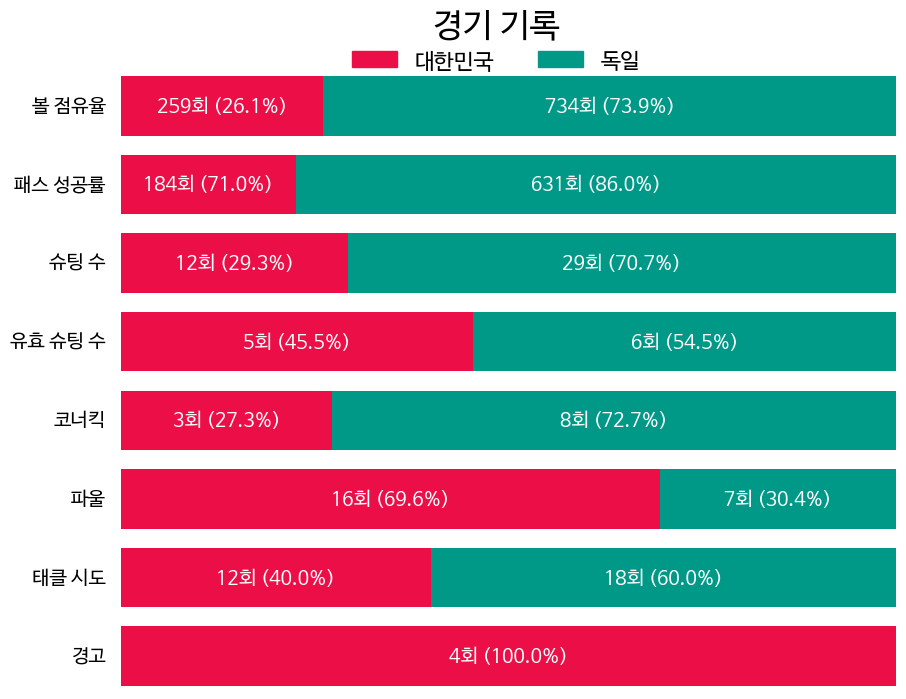

In [54]:
from statsbombpy import sb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# 0. 한글 폰트 설정 (필수)
plt.rc('font', family='NanumGothic')

# 1. 데이터 가져오기 (대한민국 vs 독일)
match_id = 7567
events = sb.events(match_id=match_id)

# 팀명 한글 변환 및 정렬을 위한 헬퍼 함수
def process_data(data, target_index=None):
    # 독일(Germany)로 변경
    name_map = {"South Korea": "대한민국", "Germany": "독일"}
    data = data.rename(index=name_map)

    # 기준 인덱스(팀 목록)가 있다면 그에 맞춤
    if target_index is not None:
        data = data.reindex(target_index, fill_value=0)

    # 대한민국을 리스트의 첫 번째(왼쪽)로 배치
    if "대한민국" in data.index:
        new_order = ["대한민국"] + [t for t in data.index if t != "대한민국"]
        data = data.reindex(new_order, fill_value=0)

    return data

# --- 데이터 집계 ---

# 1) 볼 점유율 (패스 횟수)
pass_ev = events[events['type'] == 'Pass']
pass_counts = process_data(pass_ev.groupby('team').size())

# 팀 목록 기준 설정
teams_index = pass_counts.index

# 2) 패스 성공률
pass_total = process_data(pass_ev.groupby('team').size(), teams_index)
pass_success = process_data(pass_ev[pass_ev['pass_outcome'].isnull()].groupby('team').size(), teams_index)

# 3) 슈팅 수
shot_ev = events[events['type'] == 'Shot']
shot_counts = process_data(shot_ev.groupby('team').size(), teams_index)

# 4) 유효 슈팅 수
sot_outcomes = ['Goal', 'Saved', 'Saved to Post']
sot_ev = shot_ev[shot_ev['shot_outcome'].isin(sot_outcomes)]
sot_counts = process_data(sot_ev.groupby('team').size(), teams_index)

# 5) 코너킥
if 'pass_type' in events.columns:
    corner_ev = events[(events['type'] == 'Pass') & (events['pass_type'] == 'Corner')]
    corner_counts = process_data(corner_ev.groupby('team').size(), teams_index)
else:
    corner_counts = process_data(pd.Series(dtype=int), teams_index)

# 6) 파울
if 'type' in events.columns:
    foul_ev = events[events['type'] == 'Foul Committed']
    foul_counts = process_data(foul_ev.groupby('team').size(), teams_index)
else:
    foul_counts = process_data(pd.Series(dtype=int), teams_index)

# 7) 태클
if 'duel_type' in events.columns:
    tackle_ev = events[(events['type'] == 'Duel') & (events['duel_type'] == 'Tackle')]
    tackle_counts = process_data(tackle_ev.groupby('team').size(), teams_index)
else:
    tackle_counts = process_data(pd.Series(dtype=int), teams_index)

# 8) 경고 (Yellow Card)
mask_yellow = pd.Series(False, index=events.index)
if 'foul_committed_card' in events.columns:
    mask_yellow |= events['foul_committed_card'].isin(['Yellow Card', 'Second Yellow'])
if 'bad_behaviour_card' in events.columns:
    mask_yellow |= (events['bad_behaviour_card'] == 'Yellow Card')
yellow_counts = process_data(events[mask_yellow].groupby('team').size(), teams_index)


# --- 그래프 그리기 ---

fig, axes = plt.subplots(8, 1, figsize=(10, 8))
plt.subplots_adjust(top=0.88, hspace=0.20)

# 색상 설정: 대한민국(Red), 독일(Green - 당시 원정 유니폼 색상)
colors = ['#EC0F47', '#009988']

# 제목 및 범례
fig.suptitle("경기 기록", fontsize=24, fontweight='heavy', y=0.96)
red_patch = mpatches.Patch(color=colors[0], label='대한민국')
green_patch = mpatches.Patch(color=colors[1], label='독일')
fig.legend(handles=[red_patch, green_patch], loc='upper center', bbox_to_anchor=(0.5, 0.935), ncol=2, frameon=False, fontsize=16)

def draw_stat_bar(ax, data, title, total_data=None):
    vis_total = data.sum()

    # 데이터가 아예 없는 경우
    if vis_total == 0:
        ax.set_xlim(0, 1) # 좌표계 강제 설정
    else:
        # 데이터가 있는 경우: X축 범위를 합계로 고정
        ax.set_xlim(0, vis_total)

        # 막대 그리기
        ax.barh(0, data.iloc[0], color=colors[0], height=1)
        ax.barh(0, data.iloc[1], left=data.iloc[0], color=colors[1], height=1)

        # 텍스트 라벨
        for i, (team, value) in enumerate(data.items()):
            # 0회일 경우 텍스트 출력 건너뛰기
            if value == 0:
                continue

            # 위치 계산
            x_pos = value / 2 if i == 0 else data.iloc[0] + value / 2

            # 라벨 텍스트 생성
            if total_data is not None:
                team_total = total_data.loc[team]
                pct = (value / team_total * 100) if team_total > 0 else 0
                label_text = f"{value}회 ({pct:.1f}%)"
            else:
                pct = (value / vis_total * 100)
                label_text = f"{value}회 ({pct:.1f}%)"

            # 흰색 텍스트
            ax.text(x_pos, 0, label_text,
                    ha='center', va='center', color='white', fontweight='heavy', fontsize=14)

    # 좌측 타이틀
    ax.text(-0.02, 0.5, title, transform=ax.transAxes,
            ha='right', va='center', fontsize=14, fontweight='bold', color='black')

    ax.axis('off')

# 각 그래프 출력
draw_stat_bar(axes[0], pass_counts, "볼 점유율")
draw_stat_bar(axes[1], pass_success, "패스 성공률", total_data=pass_total)
draw_stat_bar(axes[2], shot_counts, "슈팅 수")
draw_stat_bar(axes[3], sot_counts, "유효 슈팅 수")
draw_stat_bar(axes[4], corner_counts, "코너킥")
draw_stat_bar(axes[5], foul_counts, "파울")
draw_stat_bar(axes[6], tackle_counts, "태클 시도")
draw_stat_bar(axes[7], yellow_counts, "경고")

plt.show()

**2022 World Cup 대한민국 VS 가나**

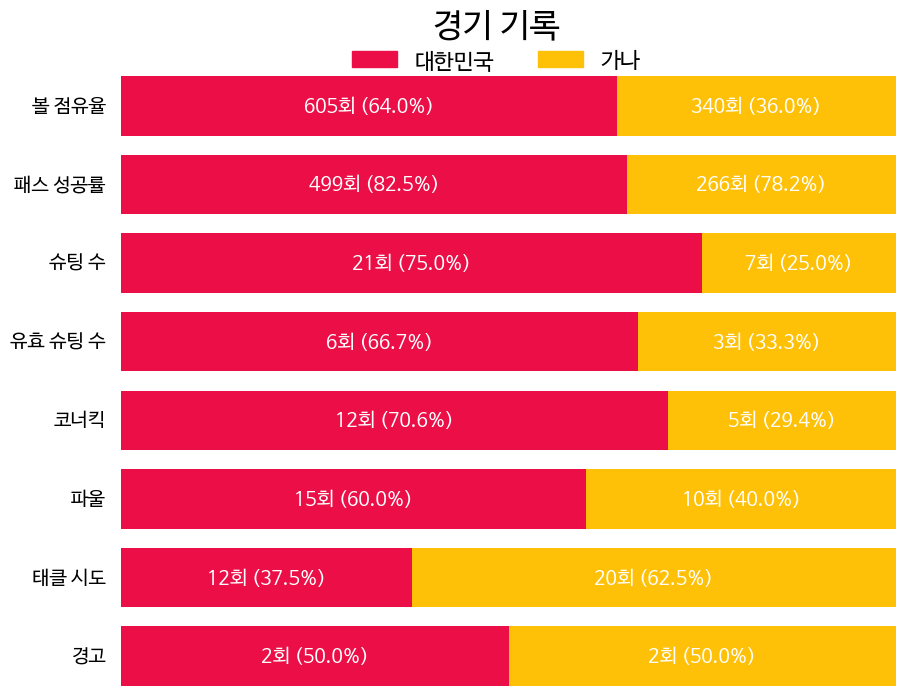

In [62]:
from statsbombpy import sb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# 1. 데이터 가져오기 (대한민국 vs 가나 - 2022 월드컵 조별리그)
match_id = 3857299
events = sb.events(match_id=match_id)

# 팀명 한글 변환 및 정렬을 위한 헬퍼 함수
def process_data(data, target_index=None):
    # 대한민국, 가나로 변경
    name_map = {"South Korea": "대한민국", "Ghana": "가나"}
    data = data.rename(index=name_map)

    # 기준 인덱스(팀 목록)가 있다면 그에 맞춤
    if target_index is not None:
        data = data.reindex(target_index, fill_value=0)

    # 대한민국을 리스트의 첫 번째(왼쪽)로 배치
    if "대한민국" in data.index:
        new_order = ["대한민국"] + [t for t in data.index if t != "대한민국"]
        data = data.reindex(new_order, fill_value=0)

    return data

# --- 데이터 집계 ---

# 1) 볼 점유율 (패스 횟수)
pass_ev = events[events['type'] == 'Pass']
pass_counts = process_data(pass_ev.groupby('team').size())

# 팀 목록 기준 설정
teams_index = pass_counts.index

# 2) 패스 성공률
pass_total = process_data(pass_ev.groupby('team').size(), teams_index)
pass_success = process_data(pass_ev[pass_ev['pass_outcome'].isnull()].groupby('team').size(), teams_index)

# 3) 슈팅 수
shot_ev = events[events['type'] == 'Shot']
shot_counts = process_data(shot_ev.groupby('team').size(), teams_index)

# 4) 유효 슈팅 수
sot_outcomes = ['Goal', 'Saved', 'Saved to Post']
sot_ev = shot_ev[shot_ev['shot_outcome'].isin(sot_outcomes)]
sot_counts = process_data(sot_ev.groupby('team').size(), teams_index)

# 5) 코너킥
if 'pass_type' in events.columns:
    corner_ev = events[(events['type'] == 'Pass') & (events['pass_type'] == 'Corner')]
    corner_counts = process_data(corner_ev.groupby('team').size(), teams_index)
else:
    corner_counts = process_data(pd.Series(dtype=int), teams_index)

# 6) 파울
if 'type' in events.columns:
    foul_ev = events[events['type'] == 'Foul Committed']
    foul_counts = process_data(foul_ev.groupby('team').size(), teams_index)
else:
    foul_counts = process_data(pd.Series(dtype=int), teams_index)

# 7) 태클
if 'duel_type' in events.columns:
    tackle_ev = events[(events['type'] == 'Duel') & (events['duel_type'] == 'Tackle')]
    tackle_counts = process_data(tackle_ev.groupby('team').size(), teams_index)
else:
    tackle_counts = process_data(pd.Series(dtype=int), teams_index)

# 8) 경고 (Yellow Card)
mask_yellow = pd.Series(False, index=events.index)
if 'foul_committed_card' in events.columns:
    mask_yellow |= events['foul_committed_card'].isin(['Yellow Card', 'Second Yellow'])
if 'bad_behaviour_card' in events.columns:
    mask_yellow |= (events['bad_behaviour_card'] == 'Yellow Card')
yellow_counts = process_data(events[mask_yellow].groupby('team').size(), teams_index)


# --- 그래프 그리기 ---

fig, axes = plt.subplots(8, 1, figsize=(10, 8))
plt.subplots_adjust(top=0.88, hspace=0.20)

# 색상 설정: 대한민국(Red), 가나(Black - '검은 별' 별칭 및 유니폼 대비 고려)
# 가나 유니폼은 흰색이지만 시각적 구분을 위해 Black(또는 짙은 회색) 사용
colors = ['#EC0F47', '#FFC107']

# 제목 및 범례
fig.suptitle("경기 기록", fontsize=24, fontweight='heavy', y=0.96)
red_patch = mpatches.Patch(color=colors[0], label='대한민국')
green_patch = mpatches.Patch(color=colors[1], label='가나')
fig.legend(handles=[red_patch, green_patch], loc='upper center', bbox_to_anchor=(0.5, 0.935), ncol=2, frameon=False, fontsize=16)

def draw_stat_bar(ax, data, title, total_data=None):
    vis_total = data.sum()

    # 데이터가 아예 없는 경우
    if vis_total == 0:
        ax.set_xlim(0, 1) # 좌표계 강제 설정
    else:
        # 데이터가 있는 경우: X축 범위를 합계로 고정
        ax.set_xlim(0, vis_total)

        # 막대 그리기
        ax.barh(0, data.iloc[0], color=colors[0], height=1)
        ax.barh(0, data.iloc[1], left=data.iloc[0], color=colors[1], height=1)

        # 텍스트 라벨
        for i, (team, value) in enumerate(data.items()):
            # 0회일 경우 텍스트 출력 건너뛰기
            if value == 0:
                continue

            # 위치 계산
            x_pos = value / 2 if i == 0 else data.iloc[0] + value / 2

            # 라벨 텍스트 생성
            if total_data is not None:
                team_total = total_data.loc[team]
                pct = (value / team_total * 100) if team_total > 0 else 0
                label_text = f"{value}회 ({pct:.1f}%)"
            else:
                pct = (value / vis_total * 100)
                label_text = f"{value}회 ({pct:.1f}%)"

            # 흰색 텍스트
            ax.text(x_pos, 0, label_text,
                    ha='center', va='center', color='white', fontweight='heavy', fontsize=14)

    # 좌측 타이틀
    ax.text(-0.02, 0.5, title, transform=ax.transAxes,
            ha='right', va='center', fontsize=14, fontweight='bold', color='black')

    ax.axis('off')

# 각 그래프 출력
draw_stat_bar(axes[0], pass_counts, "볼 점유율")
draw_stat_bar(axes[1], pass_success, "패스 성공률", total_data=pass_total)
draw_stat_bar(axes[2], shot_counts, "슈팅 수")
draw_stat_bar(axes[3], sot_counts, "유효 슈팅 수")
draw_stat_bar(axes[4], corner_counts, "코너킥")
draw_stat_bar(axes[5], foul_counts, "파울")
draw_stat_bar(axes[6], tackle_counts, "태클 시도")
draw_stat_bar(axes[7], yellow_counts, "경고")

plt.show()

**2018 World Cup 대한민국 VS 포르투갈**

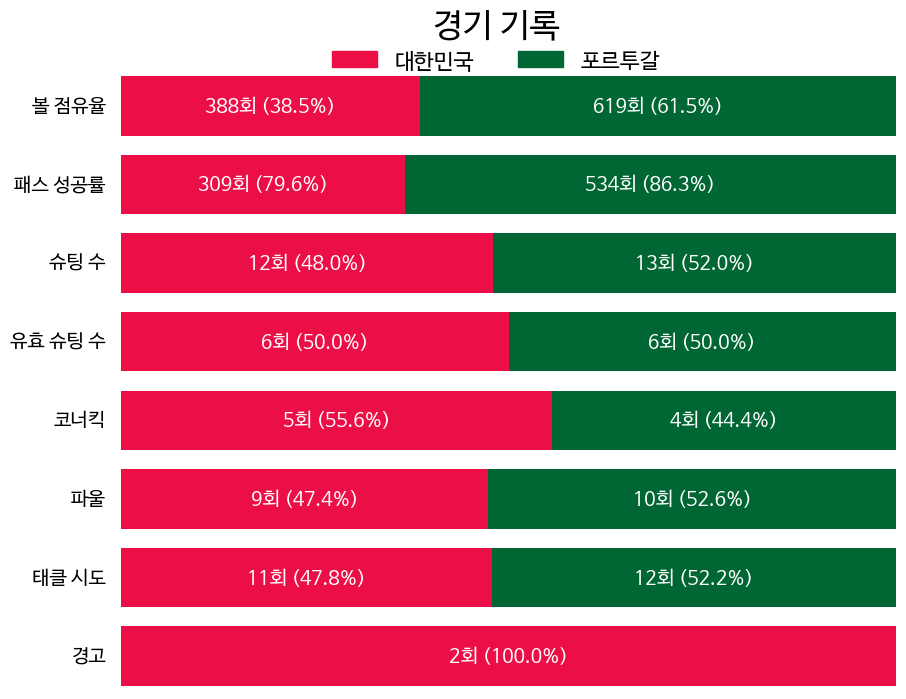

In [65]:
from statsbombpy import sb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# 1. 데이터 가져오기 (대한민국 vs 포르투갈 - 2022 월드컵 조별리그 3차전)
match_id = 3857262
events = sb.events(match_id=match_id)

# 팀명 한글 변환 및 정렬을 위한 헬퍼 함수
def process_data(data, target_index=None):
    # 대한민국, 포르투갈로 변경
    name_map = {"South Korea": "대한민국", "Portugal": "포르투갈"}
    data = data.rename(index=name_map)

    # 기준 인덱스(팀 목록)가 있다면 그에 맞춤
    if target_index is not None:
        data = data.reindex(target_index, fill_value=0)

    # 대한민국을 리스트의 첫 번째(왼쪽)로 배치
    if "대한민국" in data.index:
        new_order = ["대한민국"] + [t for t in data.index if t != "대한민국"]
        data = data.reindex(new_order, fill_value=0)

    return data

# --- 데이터 집계 ---

# 1) 볼 점유율 (패스 횟수)
pass_ev = events[events['type'] == 'Pass']
pass_counts = process_data(pass_ev.groupby('team').size())

# 팀 목록 기준 설정
teams_index = pass_counts.index

# 2) 패스 성공률
pass_total = process_data(pass_ev.groupby('team').size(), teams_index)
pass_success = process_data(pass_ev[pass_ev['pass_outcome'].isnull()].groupby('team').size(), teams_index)

# 3) 슈팅 수
shot_ev = events[events['type'] == 'Shot']
shot_counts = process_data(shot_ev.groupby('team').size(), teams_index)

# 4) 유효 슈팅 수
sot_outcomes = ['Goal', 'Saved', 'Saved to Post']
sot_ev = shot_ev[shot_ev['shot_outcome'].isin(sot_outcomes)]
sot_counts = process_data(sot_ev.groupby('team').size(), teams_index)

# 5) 코너킥
if 'pass_type' in events.columns:
    corner_ev = events[(events['type'] == 'Pass') & (events['pass_type'] == 'Corner')]
    corner_counts = process_data(corner_ev.groupby('team').size(), teams_index)
else:
    corner_counts = process_data(pd.Series(dtype=int), teams_index)

# 6) 파울
if 'type' in events.columns:
    foul_ev = events[events['type'] == 'Foul Committed']
    foul_counts = process_data(foul_ev.groupby('team').size(), teams_index)
else:
    foul_counts = process_data(pd.Series(dtype=int), teams_index)

# 7) 태클
if 'duel_type' in events.columns:
    tackle_ev = events[(events['type'] == 'Duel') & (events['duel_type'] == 'Tackle')]
    tackle_counts = process_data(tackle_ev.groupby('team').size(), teams_index)
else:
    tackle_counts = process_data(pd.Series(dtype=int), teams_index)

# 8) 경고 (Yellow Card)
mask_yellow = pd.Series(False, index=events.index)
if 'foul_committed_card' in events.columns:
    mask_yellow |= events['foul_committed_card'].isin(['Yellow Card', 'Second Yellow'])
if 'bad_behaviour_card' in events.columns:
    mask_yellow |= (events['bad_behaviour_card'] == 'Yellow Card')
yellow_counts = process_data(events[mask_yellow].groupby('team').size(), teams_index)


# --- 그래프 그리기 ---

fig, axes = plt.subplots(8, 1, figsize=(10, 8))
plt.subplots_adjust(top=0.88, hspace=0.20)

# 색상 설정: 대한민국(Red), 포르투갈(Green)
# 포르투갈은 빨강/초록이 상징색이나, 대한민국과 대비를 위해 초록색 사용
colors = ['#EC0F47', '#006633']

# 제목 및 범례
fig.suptitle("경기 기록", fontsize=24, fontweight='heavy', y=0.96)
red_patch = mpatches.Patch(color=colors[0], label='대한민국')
green_patch = mpatches.Patch(color=colors[1], label='포르투갈')
fig.legend(handles=[red_patch, green_patch], loc='upper center', bbox_to_anchor=(0.5, 0.935), ncol=2, frameon=False, fontsize=16)

def draw_stat_bar(ax, data, title, total_data=None):
    vis_total = data.sum()

    # 데이터가 아예 없는 경우
    if vis_total == 0:
        ax.set_xlim(0, 1) # 좌표계 강제 설정
    else:
        # 데이터가 있는 경우: X축 범위를 합계로 고정
        ax.set_xlim(0, vis_total)

        # 막대 그리기
        ax.barh(0, data.iloc[0], color=colors[0], height=1)
        ax.barh(0, data.iloc[1], left=data.iloc[0], color=colors[1], height=1)

        # 텍스트 라벨
        for i, (team, value) in enumerate(data.items()):
            # 0회일 경우 텍스트 출력 건너뛰기
            if value == 0:
                continue

            # 위치 계산
            x_pos = value / 2 if i == 0 else data.iloc[0] + value / 2

            # 라벨 텍스트 생성
            if total_data is not None:
                team_total = total_data.loc[team]
                pct = (value / team_total * 100) if team_total > 0 else 0
                label_text = f"{value}회 ({pct:.1f}%)"
            else:
                pct = (value / vis_total * 100)
                label_text = f"{value}회 ({pct:.1f}%)"

            # 텍스트 색상: 둘 다 배경이 진하므로 흰색 사용
            text_color = 'white'

            ax.text(x_pos, 0, label_text,
                    ha='center', va='center', color=text_color, fontweight='heavy', fontsize=14)

    # 좌측 타이틀
    ax.text(-0.02, 0.5, title, transform=ax.transAxes,
            ha='right', va='center', fontsize=14, fontweight='bold', color='black')

    ax.axis('off')

# 각 그래프 출력
draw_stat_bar(axes[0], pass_counts, "볼 점유율")
draw_stat_bar(axes[1], pass_success, "패스 성공률", total_data=pass_total)
draw_stat_bar(axes[2], shot_counts, "슈팅 수")
draw_stat_bar(axes[3], sot_counts, "유효 슈팅 수")
draw_stat_bar(axes[4], corner_counts, "코너킥")
draw_stat_bar(axes[5], foul_counts, "파울")
draw_stat_bar(axes[6], tackle_counts, "태클 시도")
draw_stat_bar(axes[7], yellow_counts, "경고")

plt.show()